In [1]:
import numpy as np
import matplotlib.pyplot as plt
import string
import os
from sklearn.model_selection import train_test_split

In [2]:
lyrics_directory = "lyrics"
files = []

for file in os.listdir(lyrics_directory):
    files.append(file)

In [3]:
files

['Drake_lyrics.txt',
 'Eminem_lyrics.txt',
 'J Cole_lyrics.txt',
 'Jay-z_lyrics.txt',
 'Kanye West_lyrics.txt',
 'Kendrick Lamar_lyrics.txt']

In [4]:
lyrics_lines = []
labels = []
artists = []

for label, file in enumerate(files):
    artists.append(file)

    dir = os.path.join(lyrics_directory, file)
    for line in open(dir, encoding='utf8'):
        line = line.rstrip().lower()
        
        if line:
            line = line.translate(str.maketrans('', '', string.punctuation))

            lyrics_lines.append(line)
            labels.append(label)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(lyrics_lines, labels)

In [6]:
len(y_train), len(y_test)

(22233, 7411)

In [7]:
idx = 1
word2idx = {'unknown': 0}

for line in x_train:
    tokens = line.split()
    for token in tokens:
        if token not in word2idx:
            word2idx[token] = idx
            idx += 1

In [8]:
x_train_int = []
x_test_int = []

for line in x_train:
  tokens = line.split()
  line_as_int = [word2idx[token] for token in tokens]
  x_train_int.append(line_as_int)

for line in x_test:
  tokens = line.split()
  line_as_int = [word2idx.get(token, 0) for token in tokens]
  x_test_int.append(line_as_int)

In [9]:
V = len(word2idx)

log_probabilities = []

for i in range(len(artists)):
    A = np.ones((V, V))
    pi = np.ones(V)
    log_probabilities.append({"A": A, "pi": pi})

In [10]:
def compute_log_probabilities(x_train_int, y_train, log_probabilities):

    for i in range(len(x_train_int)):
        line = x_train_int[i]
        artist = y_train[i]

        last_token_idx = None
        for token_idx in line:
            if last_token_idx is None:
                log_probabilities[artist]['pi'][token_idx] += 1
            else:
                log_probabilities[artist]["A"][last_token_idx, token_idx] += 1
            last_token_idx = token_idx

    for artist in range(len(log_probabilities)):
        log_probabilities[artist]["A"] /= log_probabilities[artist]["A"].sum(axis=1, keepdims=True)
        log_probabilities[artist]["pi"] /= log_probabilities[artist]["pi"].sum()

        log_probabilities[artist]["A"] = np.log(log_probabilities[artist]["A"])
        log_probabilities[artist]["pi"] = np.log(log_probabilities[artist]["pi"])

compute_log_probabilities(x_train_int, y_train, log_probabilities)

In [11]:
priors = []
total = len(y_train)

for i in range(len(artists)):
    count = sum(y == i for y in y_train)
    priors.append(count/total)

In [12]:
class rapClassifier:
    def __init__(self, log_probabilities, priors, artists):
        self.log_probabilities = log_probabilities
        self.priors = priors
        self.artists = artists

    def _compute_probability(self, input, artist):
        A = self.log_probabilities[artist]["A"]
        pi = self.log_probabilities[artist]["pi"]

        last_token_idx = None
        probability = 0
        for token_idx in input:
            if last_token_idx is None:
                probability += pi[token_idx]
            else:
                probability += A[last_token_idx, token_idx]

        return probability

    def predict(self, lines):
        predictions = np.zeros(len(lines))
        for i, line in enumerate(lines):
            posteriors = [self._compute_probability(line, artist) + self.priors[artist] \
                          for artist in range(len(self.artists))]
            prediction = np.argmax(posteriors)
            predictions[i] = prediction
        return predictions

    def predict_line(self, line):
        posteriors = [self._compute_probability(line, artist) + self.priors[artist] \
                      for artist in range(len(self.artists))]
        prediction = np.argmax(posteriors)
        return prediction

In [13]:
classifier = rapClassifier(log_probabilities, priors, artists)

In [14]:
Ptrain = classifier.predict(x_train_int)
print(f"Train acc: {np.mean(Ptrain == y_train)}")

Train acc: 0.35802635721674986


In [15]:
Ptest = classifier.predict(x_test_int)
print(f"Test acc: {np.mean(Ptest == y_test)}")

Test acc: 0.32829577654837405


In [16]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [17]:
from sklearn.metrics import confusion_matrix

Confusion matrix, without normalization
[[127 301 185  57  43 281]
 [ 49 969 175  68  56 359]
 [ 44 321 340  72  46 330]
 [ 33 319 188 189  66 273]
 [ 68 311 178  86 193 327]
 [ 42 367 170  94  69 615]]


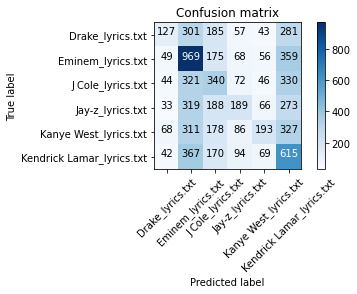

In [18]:
cm = confusion_matrix(y_test, Ptest)
plot_confusion_matrix(cm, artists)